<a href="https://colab.research.google.com/github/qpwisu/Financial_data_analysis/blob/main/%EC%9B%90%EC%9E%90%EC%9E%AC%EC%99%80_%EC%A3%BC%EC%8B%9D%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#한글 그래프에 나오게
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install bs4
!pip install pykrx


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

     |████████████████████████████████| 92 kB 429 kB/s 
     |████████████████████████████████| 51 kB 466 kB/s 
     |████████████████████████████████| 251 kB 41.1 MB/s 


In [3]:
#https://buyandpray.tistory.com/39
#https://kr.investing.com/에서 ajax를 통해 서버에 요청해 철광석 가격을 받아왔다
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
def x(y):
  z=re.sub(",","",y)
  return z
def getRawMaterials(st_date, end_date, curr_id, smlID , name):
  headers = {
    'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36',
    'X-Requested-With' : 'XMLHttpRequest'
  }
  formData = {
      "curr_id" : curr_id,
      "smlID" :smlID,
      "header" : "",
      "st_date" : st_date,
      "end_date" : end_date,
      "interval_sec" : "Daily",
      "sort_col" : "date",
      "sort_ord" : "DESC",
      "action" : "historical_data"
  }

  POSTURL = r"https://kr.investing.com/instruments/HistoricalDataAjax"


  formData["header"] = name + " 내역"

  response = requests.post(POSTURL, headers=headers, data=formData)
  if response.status_code == 200:
      html = response.text
      soup = BeautifulSoup(html,'html.parser') 
      items= soup.select("tr")
      items = items[1:-1]
      li= []

      for item in items:
        i = item.text.split("\n")[1:7]
        i[0]=re.sub(r"(\d{4})년 (\d{2})월 (\d{2})일",r"\g<1>\g<2>\g<3>",i[0])
        i.append(i[5].split(" ")[1])
        i[5]= i[5].split(" ")[0]
        li.append(i)
      name_list = ["날짜","종가","오픈","고가",'저기',"거래량","변동%"]
      df = pd.DataFrame(li,columns=name_list)
      df.set_index("날짜",inplace=True)
      df=df[::-1]
      
      index1 =df["종가"].apply(x).to_frame(name=name)

      index1=index1.astype('float')
      index1.reset_index(inplace=True)
      index1=index1.astype({'날짜':'string'})
      index1.set_index("날짜",inplace=True)
      return index1
   

In [4]:
from pykrx import stock
from pykrx import bond
from tqdm import tqdm
def stock_price(index1,stock_li):
  for i in tqdm(stock_li):
    df2 = stock.get_market_ohlcv("20210601", "20220213", i)
    index2 = df2["종가"].to_frame(name=i)
    index2=index2.astype('float')
    index2.reset_index(inplace=True)
    index2=index2.astype({'날짜':'string'})
    index2.set_index("날짜",inplace=True)
    index1=pd.merge(index1, index2,left_index=True, right_index=True ,how='outer')
  return index1
    

철광석의 경우 관련 종목과의 상관관계가 양의 상관계수로 꽤 높게 측정된다. 철광석가격이 오를 수록 주가 역시 오른다 

060380    0.616154

084010    0.588009

017480    0.587893

008260    0.571037

002220    0.515273

철광석       1.000000
060380    0.616154
084010    0.588009
017480    0.587893
008260    0.571037
002220    0.515273
001080    0.465454
001230    0.325647
016380    0.296960
058430    0.022253
Name: 철광석, dtype: float64


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52384 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44305 missing from current font.
  font.set_text

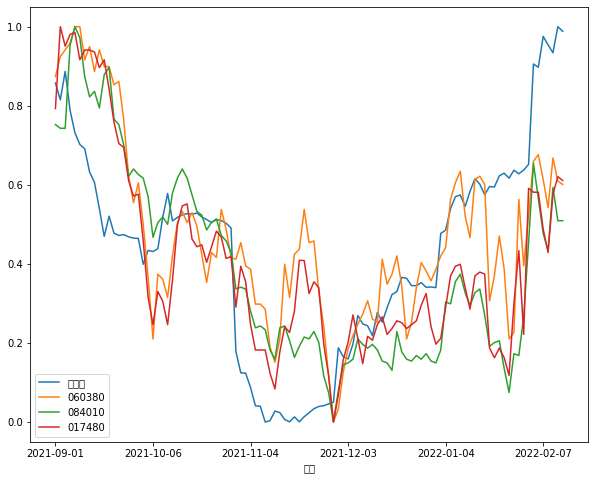

In [ ]:
index1=getRawMaterials("2021/09/01","2022/02/15","961729","301009","철광석")
stock_li = ["001230","060380","001080","017480","084010","058430","002220","008260","016380"]
index1= stock_price(index1,stock_li)
index1 =index1.dropna(axis=0)
#상관관계 1998140207971
corr = index1.corr(method = 'pearson')
high_correlation=corr.iloc[0].sort_values(ascending = False)[0:4].index.tolist()
high_correlation=index1[high_correlation]
print(corr.iloc[0].sort_values(ascending = False))

#정규화
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())
df_minmax_norm = minmax_norm(high_correlation)
df_minmax_norm.plot.line(figsize=(10,8))

구리와 관련주들의 상관계수가 낮은편이다 큰 영향을 끼치지 않는다는 의미 

구리        1.000000
025820    0.112664
103140    0.077099
012800   -0.011777
021050   -0.182484
229640   -0.098569
Name: 구리, dtype: float64


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text

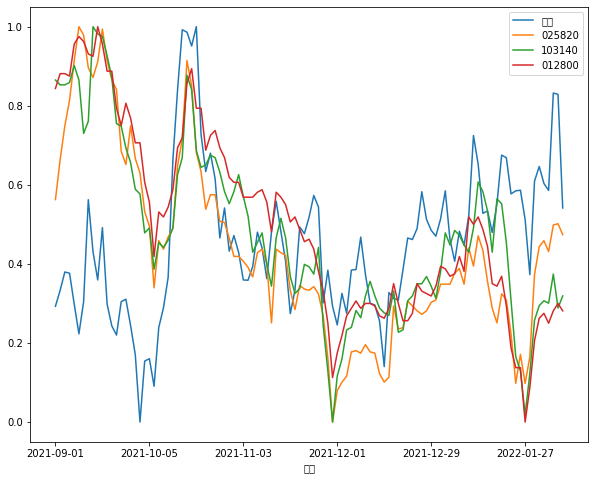

In [ ]:
index1=getRawMaterials("2021/09/01","2022/02/15","8831","300012","구리")

stock_li = ["025820","103140","012800","021050","229640"]
index1= stock_price(index1,stock_li)
index1 =index1.dropna(axis=0)
#상관관계 1998140207971
corr = index1.corr(method = 'pearson')
high_correlation=corr.iloc[0].sort_values(ascending = False)[0:4].index.tolist()
high_correlation=index1[high_correlation]
print(corr.iloc[0])

#정규화
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())
df_minmax_norm = minmax_norm(high_correlation)
df_minmax_norm.plot.line(figsize=(10,8))


알루미늄도 상관계수가 낮게 나온다 

알루미늄      1.000000
006110    0.095683
001530   -0.068785
018470    0.299780
069460   -0.263459
128660   -0.107890
186230    0.226369
054410    0.040189
009620   -0.325253
008350   -0.063591
009520   -0.207327
177830    0.303111
Name: 알루미늄, dtype: float64


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50508 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47336 missing from current font.
  font.set_text

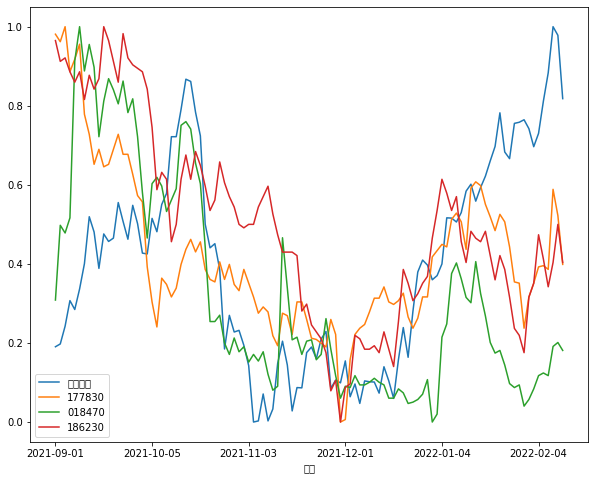

In [ ]:
index1=getRawMaterials("2021/09/01","2022/02/15","49768","300586","알루미늄")
stock_li = ["006110","001530","018470","069460","128660","186230","054410","009620","008350","009520","177830"]
index1= stock_price(index1,stock_li)
index1 =index1.dropna(axis=0)
#상관관계 1998140207971
corr = index1.corr(method = 'pearson')
high_correlation=corr.iloc[0].sort_values(ascending = False)[0:4].index.tolist()
high_correlation=index1[high_correlation]
print(corr.iloc[0])

#정규화
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())
df_minmax_norm = minmax_norm(high_correlation)
df_minmax_norm.plot.line(figsize=(10,8))

In [6]:
#모든종목 종가 dataframe으로 가져오기 

start_day = "20180101"
end_day = "20220216"
def str_day(d):
  return d.strftime('%Y%m%d')
tmp = stock.get_market_ohlcv(start_day, end_day, "005930")
days= list(map(str_day,tmp.index.to_list()))


tmp = stock.get_market_ohlcv(days[0], market="ALL")
df_stock=tmp["종가"].to_frame(name=days[0]).T
for day in tqdm(days[1:]):
  ddf = stock.get_market_ohlcv(day, market="ALL")
  a=ddf["종가"].to_frame(name=day).T
  df_stock=pd.concat([df_stock,a])

100%|██████████| 1015/1015 [19:37<00:00,  1.16s/it]


In [9]:
start_day2 = start_day[0:4]+"/"+start_day[4:6]+"/"+start_day[6:8]
end_day2 = end_day[0:4]+"/"+end_day[4:6]+"/"+end_day[6:8]
id_list=[["49768","300586","알루미늄"],["8831","300012","구리"],["961729","301009","철광석"],["8849","300060","WTI유"],["8862","300092","천연가스"],["8830","300004","금"],["959208","300751","니켈"],["8848","300052","탄소배출권"]]

index1=getRawMaterials(start_day2,end_day2,id_list[0][0],id_list[0][1],id_list[0][2])

for i in range(1,len(id_list)):
  curr_id=id_list[i][0]
  smlID=id_list[i][1]
  header=id_list[i][2]
  index2=getRawMaterials(start_day2,end_day2,curr_id,smlID,header)
  index1=pd.merge(index1, index2,left_index=True, right_index=True ,how='outer')




index1 =index1.fillna(method='ffill')
index1 = index1.dropna(axis=0)
index1
# index2=index2.astype('float')
# index2.reset_index(inplace=True)
# index2=index2.astype({'날짜':'string'})
# index2.set_index("날짜",inplace=True)


,알루미늄,구리,철광석,WTI유,천연가스,금,니켈,탄소배출권
날짜,,,,,,,,
20180102,2267.00,3.3635,73.90,60.37,3.056,1400.1,12650.0,8.11
20180103,2228.50,3.3505,73.43,61.63,3.008,1404.0,12447.5,8.13
20180104,2250.00,3.3570,74.61,62.01,2.880,1407.3,12642.5,8.07
20180105,2201.75,3.3280,75.39,61.44,2.795,1408.3,12547.5,8.08
20180108,2173.00,3.3230,76.99,61.73,2.835,1407.4,12580.0,7.96
...,...,...,...,...,...,...,...,...
20220211,3136.50,4.4385,150.87,93.10,3.941,1842.1,23051.0,92.68
20220213,3136.50,4.4727,150.87,93.10,3.941,1842.1,23051.0,92.68
20220214,3214.50,4.5020,146.76,95.46,4.195,1869.4,23170.0,92.00


In [11]:

#상관관계 1998140207971
corr = index1.corr(method = 'spearman')
corr.abs()

,알루미늄,구리,철광석,WTI유,천연가스,금,니켈,탄소배출권
알루미늄,1.000000,0.876873,0.229064,0.840784,0.839722,0.093827,0.610705,0.388636
구리,0.876873,1.000000,0.528684,0.635823,0.663874,0.454340,0.740614,0.552763
철광석,0.229064,0.528684,1.000000,0.010759,0.074316,0.783430,0.631837,0.837622
WTI유,0.840784,0.635823,0.010759,1.000000,0.705375,0.179329,0.474980,0.266975
천연가스,0.839722,0.663874,0.074316,0.705375,1.000000,0.041660,0.421482,0.312503
금,0.093827,0.454340,0.783430,0.179329,0.041660,1.000000,0.636717,0.638398
니켈,0.610705,0.740614,0.631837,0.474980,0.421482,0.636717,1.000000,0.715527
탄소배출권,0.388636,0.552763,0.837622,0.266975,0.312503,0.638398,0.715527,1.000000


전종목들과 알루미늄, 구리 , 철광석의 상관관계를 구했지만 
관련주의 상관계수가 높게 나온게 아니고 이상한 종목들이 나왔다. 

그나마 구리와 영원무역을 주목할만하다 

In [3]:
import os
plt.rc('font', family='NanumBarunGothic')

NameError: ignored

In [48]:

def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
for i in range(0,len(corr.index)):
  high_correlation=corr.iloc[i].sort_values(ascending = False)[0:2].index.tolist()
  print(high_correlation)
  print(corr.iloc[i].sort_values(ascending = False)[0:5].tolist())
  df_mean_norm = mean_norm(index1[high_correlation])
  df_mean_norm.plot.line(figsize=(20,15))


SyntaxError: ignored